## Soft Actor-Critic

### Value Iteration

In [1]:
import jax.numpy as jnp
import jax.random as jrandom

import jax

from src.systems.linear import StochasticDoubleIntegrator
from src.RL.PolicyGradient.SoftActorCritic.main import *

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm


In [2]:
def optimal_control(state):
    K = jnp.array([1, .5])
    return -jnp.dot(K, state), 0

In [3]:
seed = 1

key = jrandom.PRNGKey(seed)
buffer_size = 1000

# Init environment
x0 = jnp.array([2, 0])
SDI = StochasticDoubleIntegrator(x0)
SAC = SoftActorCritic(2, 1, key, buffer_size=buffer_size)

# Set learning rates
SAC.SVF.eta = 1e-1
SAC.SQF_1.eta = 1e-1
SAC.SQF_2.eta = 1e-1
SAC.PI.eta = 1e0

Nx = 10
x_space = np.linspace(-5, 5, Nx)
v_space = np.linspace(-5, 5, Nx)
u_space = np.linspace(-4, 4, 10)

def cost_to_normalized_reward(x):
    x = x/4.1
    return 1 - min(x, 1)

for x in x_space:
    for v in v_space:
        state = jnp.array([x, v])
        for u in u_space:
            cost = SDI.cost(state, u)
            key, _ = jrandom.split(key)
            new_state = SDI.get_state_update(key, state, u)
            SAC.ReplayBuffer.store((state, u, cost_to_normalized_reward(cost), new_state))

buffer = SAC.ReplayBuffer

In [8]:
SAC.train(key, batch_size=100, n_epochs=200, show=False)

In [8]:
SAC.PI.model.mu_layer.weight

DeviceArray([[0.21265228, 0.00130508]], dtype=float32)

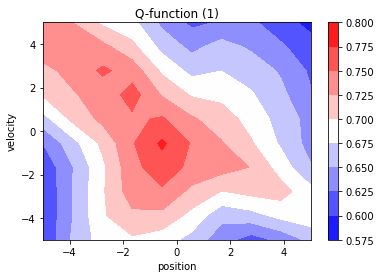

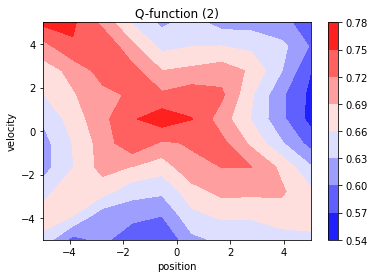

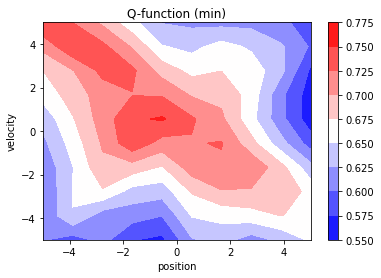

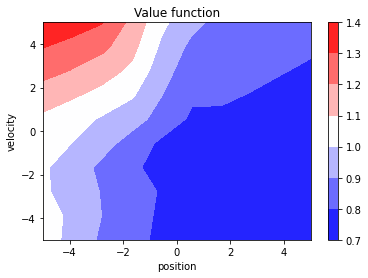

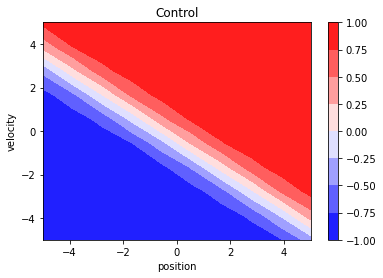

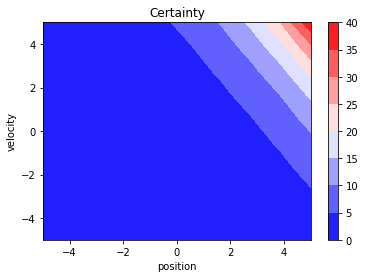

In [9]:
from matplotlib import cm
n=10
x = np.linspace(-5,5,n)
y = np.linspace(-5,5,n)
xv, yv = np.meshgrid(x,y)
zv = np.zeros((n, n))
zq = np.zeros((n, n))
zq1 = np.zeros((n,n))
zq2 = np.zeros((n,n))
zu = np.zeros((n, n))
zp = np.zeros((n, n))

Nu = 20
u_space = np.linspace(-4, 4, Nu)
Q = np.zeros(((n,n,Nu)))

for i in range(n):
    for j in range(n):
        for k in range(Nu):
            u = u_space[k]
            q1_val = SAC.SQF_1.predict(jnp.array([xv[i,j], yv[i,j]]), u)
            q2_val = SAC.SQF_2.predict(jnp.array([xv[i,j], yv[i,j]]), u)
            Q[i,j,k] = min(q1_val, q2_val)
        v_val = SAC.SVF.predict(jnp.array([xv[i,j], yv[i,j]]))
        q1_val = SAC.SQF_1.predict(jnp.array([xv[i,j], yv[i,j]]), 0)
        q2_val = SAC.SQF_2.predict(jnp.array([xv[i,j], yv[i,j]]), 0)
        q_val = min(q1_val, q2_val)
        u_val, u_std = SAC.PI.model.predict(jnp.array([xv[i,j], yv[i,j]]), squash=True)
        #_, u_val = SAC.get_control(jnp.array([xv[i,j], yv[i,j]]))
        zv[i,j] = v_val
        zu[i,j] = u_val
        zp[i,j] = u_std
        zq[i,j] = q_val
        zq1[i,j] = q1_val
        zq2[i,j] = q2_val

plt.contourf(xv, yv, zq1, cmap=cm.bwr)
plt.xlabel('position')
plt.ylabel('velocity')
plt.colorbar()
plt.title('Q-function (1)')
plt.show()

plt.contourf(xv, yv, zq2, cmap=cm.bwr)
plt.xlabel('position')
plt.ylabel('velocity')
plt.colorbar()
plt.title('Q-function (2)')
plt.show()

plt.contourf(xv, yv, zq, cmap=cm.bwr)
plt.xlabel('position')
plt.ylabel('velocity')
plt.colorbar()
plt.title('Q-function (min)')
plt.show()

plt.contourf(xv, yv, zv, cmap=cm.bwr)
plt.xlabel('position')
plt.ylabel('velocity')
plt.colorbar()
plt.title('Value function')
plt.show()

plt.contourf(xv, yv, zu, cmap=cm.bwr)
plt.xlabel('position')
plt.ylabel('velocity')
plt.colorbar()
plt.title('Control')
plt.show()

plt.contourf(xv, yv, zp, cmap=cm.bwr)
plt.xlabel('position')
plt.ylabel('velocity')
plt.colorbar()
plt.title('Certainty')
plt.show()



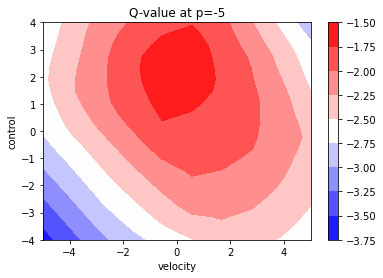

In [8]:
uw, yw = np.meshgrid(u_space, y)

plt.contourf(yw, uw, Q[0,:,:], cmap=cm.bwr)
plt.xlabel('velocity')
plt.ylabel('control')
plt.colorbar()
plt.title('Q-value at p=-5')
plt.show()


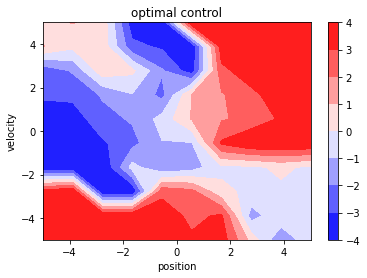

In [10]:
Q_idx = np.argmax(Q, axis=2)
Qu = np.zeros_like(Q_idx, dtype=np.float32)
for i, row in enumerate(Q_idx):
    for j, item in enumerate(row):
        Qu[i,j] = u_space[item]

plt.contourf(xv, yv, Qu, cmap=cm.bwr)
plt.xlabel('position')
plt.ylabel('velocity')
plt.colorbar()
plt.title('optimal control')
plt.show()

# Simulate plot

In [ ]:
n = 10

for seed in np.arange(0,1,1):
    key = jrandom.PRNGKey(seed)
    SAC = SoftActorCritic(2, 1, key, buffer_size=buffer_size)
    SAC.ReplayBuffer = buffer

    SAC.train(key, batch_size=100, n_epochs=100, show=False)

    x = np.linspace(-5,5,n)
    y = np.linspace(-5,5,n)
    xv, yv = np.meshgrid(x,y)
    zu = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            u_val, _ = SAC.PI.model.predict(jnp.array([xv[i,j], yv[i,j]]), squash=True)
            zu[i,j] = u_val
    plt.contourf(xv, yv, zu, cmap=cm.bwr)
    plt.xlabel('position')
    plt.ylabel('velocity')
    plt.colorbar()
    plt.title(f'Control at seed={seed}')
    plt.show()
